In [1]:
import pandas as pd
from pandas import read_csv
import os
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/')

plt.style.use('ggplot')
sns.set(font_scale=1.4)  # larger font

In [2]:
analysis_years = [2018, 2040]
faf_code = [62, 64, 65, 69]
combined_b2b_flow = None

output_dir_lookup = {2018: 'outputs_SF',
                     2040: 'outputs_SF_2040'
}
for year in analysis_years:
    directory_to_load = output_dir_lookup[year]
    b2b_flow_by_year = read_csv(directory_to_load + '/processed_b2b_flow_summary.csv')
    b2b_flow_by_year.loc[:, 'Year'] = year
    combined_b2b_flow = pd.concat([combined_b2b_flow, b2b_flow_by_year])
    
combined_b2b_flow.head(5)    

,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance,Year
0,0,11.0,Birmingham,62.0,Sacramento,3.0,interm_food,For-hire Truck,439115.906935,0.159008,8,0,1,2761.590000,2018
1,1,11.0,Birmingham,62.0,Sacramento,3.0,interm_food,Rail/IMX,153427.403537,0.059628,3,0,1,2573.070582,2018
2,2,11.0,Birmingham,65.0,Fresno,4.0,mfr_goods,Air,558.708099,0.000299,23,0,1,1867.950344,2018
3,3,11.0,Birmingham,65.0,Fresno,4.0,mfr_goods,For-hire Truck,3919.068925,0.001574,121,0,1,2490.610000,2018
4,4,11.0,Birmingham,65.0,Fresno,4.0,mfr_goods,Parcel,12898.869587,0.006905,531,0,1,1867.950344,2018


In [3]:
# total production
print(len(combined_b2b_flow))
region_production = \
combined_b2b_flow.loc[combined_b2b_flow['orig_FAFID'].isin(faf_code)]
print(len(region_production))
region_production_total = \
region_production.groupby(['Year', 'mode_choice'])[['ShipmentLoad']].sum()
region_production_total = region_production_total.reset_index()
region_production_to_plot = \
pd.pivot_table(region_production_total,
               values='ShipmentLoad', 
               index=['Year'],
               columns=['mode_choice'], 
               aggfunc=np.sum, sort = False)
region_production_to_plot.loc[:, 'Total load'] = \
region_production_to_plot.sum(axis = 1)
region_production_to_plot.loc[:, 'Truck load'] = \
region_production_to_plot.loc[:, 'For-hire Truck'] + region_production_to_plot.loc[:, 'Private Truck']
region_production_to_plot = region_production_to_plot.reset_index()
region_production_to_plot = region_production_to_plot[['Year', 'Total load', 'Truck load']]

region_production_to_plot.head(5)

6242
3590


mode_choice,Year,Total load,Truck load
0,2018,9.880411e+05,790424.242732
1,2040,1.315166e+06,909863.977438


In [4]:
# total consumption
print(len(combined_b2b_flow))
region_consumption = \
combined_b2b_flow.loc[combined_b2b_flow['dest_FAFID'].isin(faf_code)]
print(len(region_consumption))
region_consumption_total = \
region_consumption.groupby(['Year', 'mode_choice'])[['ShipmentLoad']].sum()
region_consumption_total = region_consumption_total.reset_index()
region_consumption_to_plot = \
pd.pivot_table(region_consumption_total,
               values='ShipmentLoad', 
               index=['Year'],
               columns=['mode_choice'], 
               aggfunc=np.sum, sort = False)
region_consumption_to_plot.loc[:, 'Total load'] = \
region_consumption_to_plot.sum(axis = 1)
region_consumption_to_plot.loc[:, 'Truck load'] = \
region_consumption_to_plot.loc[:, 'For-hire Truck'] + \
region_consumption_to_plot.loc[:, 'Private Truck']
region_consumption_to_plot = region_consumption_to_plot.reset_index()
region_consumption_to_plot = region_consumption_to_plot[['Year', 'Total load', 'Truck load']]
region_consumption_to_plot.head(5)

6242
2913


mode_choice,Year,Total load,Truck load
0,2018,857982.992869,794279.850601
1,2040,908865.394706,790347.837251


In [5]:
region_production_to_plot.columns = \
['Year', 'Total production (1000 ton)', 'Production shipped by truck (1000 ton)']
region_consumption_to_plot.columns = \
['Year', 'Total consumption (1000 ton)', 'Consumption shipped by truck (1000 ton)']
region_flow_to_plot = pd.merge(region_production_to_plot,
                              region_consumption_to_plot,
                              on = 'Year', how = 'left')
region_flow_to_plot.loc[:, 'Total load'] = \
region_flow_to_plot.loc[:, 'Total production (1000 ton)'] + \
region_flow_to_plot.loc[:, 'Total consumption (1000 ton)']

region_flow_to_plot.loc[:, 'Truck load'] = \
region_flow_to_plot.loc[:, 'Production shipped by truck (1000 ton)'] + \
region_flow_to_plot.loc[:, 'Consumption shipped by truck (1000 ton)']
region_flow_to_plot.head(5)


,Year,Total production (1000 ton),Production shipped by truck (1000 ton),Total consumption (1000 ton),Consumption shipped by truck (1000 ton),Total load,Truck load
0,2018,9.880411e+05,790424.242732,857982.992869,794279.850601,1.846024e+06,1.584704e+06
1,2040,1.315166e+06,909863.977438,908865.394706,790347.837251,2.224031e+06,1.700212e+06


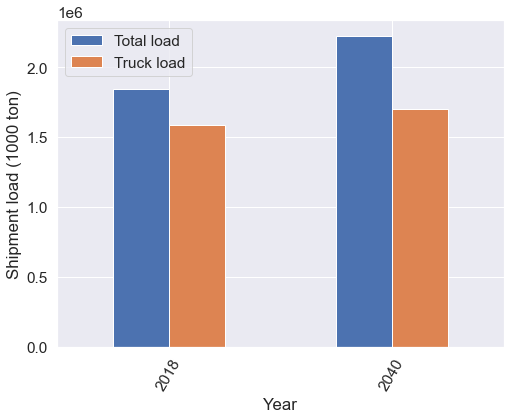

In [6]:
# plt.figure(figsize = (6,5))
region_flow_to_plot[['Year', 'Total load', \
                     'Truck load']].plot(kind = 'bar', x = 'Year', figsize=(8,6))
plt.xticks(rotation = 60)
plt.ylabel('Shipment load (1000 ton)')
plt.savefig('plots/SynthFirm_demand_forecast.png', dpi = 300, bbox_inches = 'tight')
plt.show()

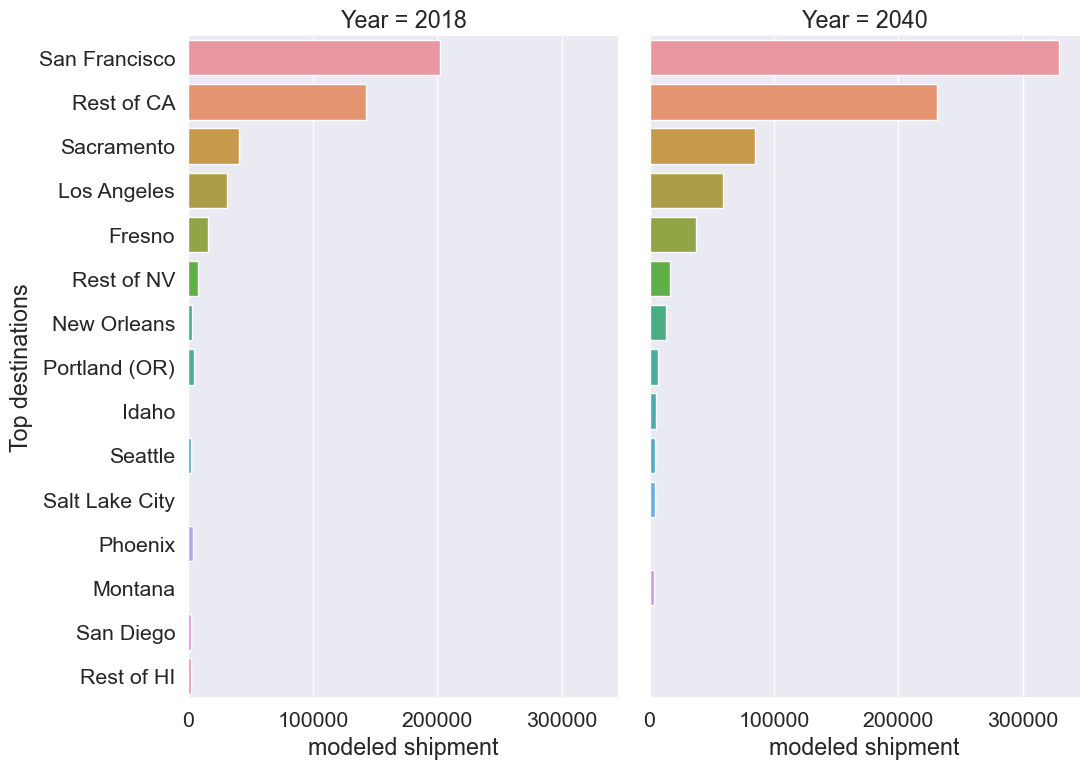

In [23]:
# DESTINATIONS
nzones = 12
plot_dir = 'plots_SF_2040/'
agg_modeled_outflow_destination = \
combined_b2b_flow.groupby(['dest_FAFID', 'dest_FAFNAME', 'Year'])[['ShipmentLoad']].sum()

agg_modeled_outflow_destination = \
agg_modeled_outflow_destination.rename(columns={'ShipmentLoad':'modeled shipment'})

agg_modeled_outflow_destination = \
agg_modeled_outflow_destination.reset_index()

agg_modeled_outflow_destination = \
agg_modeled_outflow_destination.sort_values('modeled shipment', 
                                             ascending = False)
agg_modeled_outflow_destination = \
agg_modeled_outflow_destination.groupby('Year').head(nzones)
agg_modeled_outflow_destination = \
agg_modeled_outflow_destination.reset_index()

# plt.figure(figsize = (12,8))
ax = sns.catplot(kind = 'bar', data = agg_modeled_outflow_destination,
           y = 'dest_FAFNAME', x = 'modeled shipment', col = 'Year', 
                 height=8, aspect = 0.7)
ax.set(ylabel ="Top destinations")

plt.savefig(plot_dir + 'outflow_load_comparison.png', 
            bbox_inches = 'tight', dpi = 200)
# plt.show()
# agg_modeled_outflow_destination.head(10)

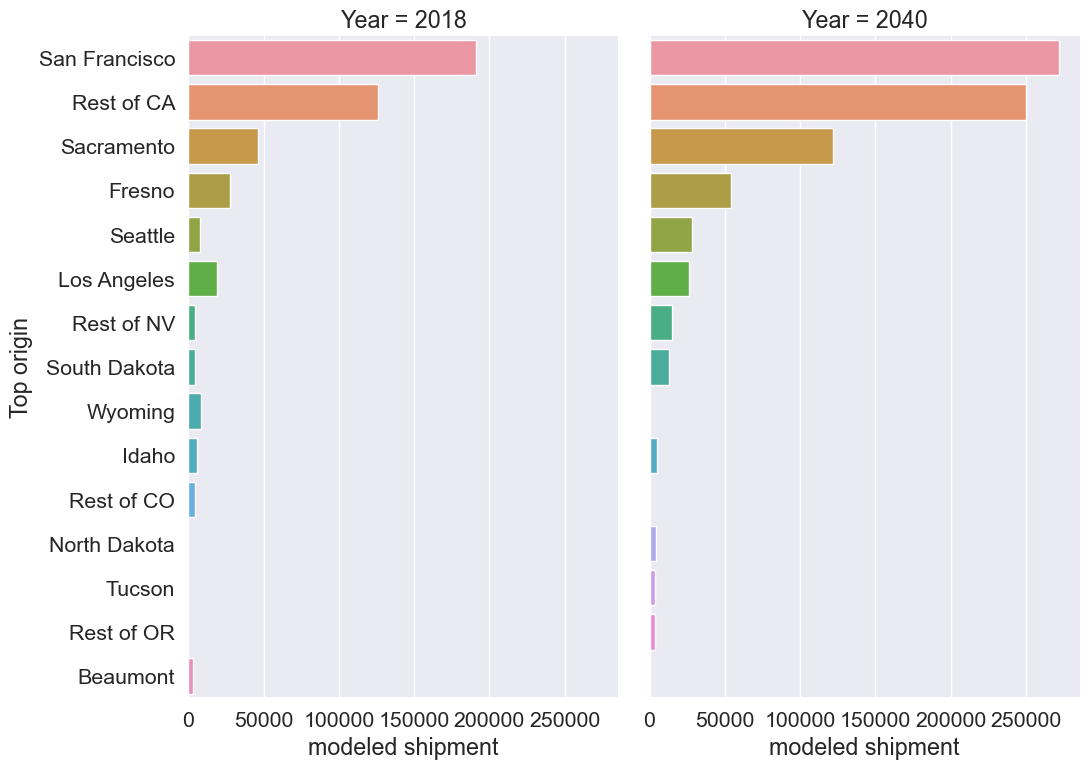

In [24]:
# DESTINATIONS
nzones = 12
plot_dir = 'plots_SF_2040/'
agg_modeled_inflow_destination = \
combined_b2b_flow.groupby(['orig_FAFID', 'orig_FAFNAME', 'Year'])[['ShipmentLoad']].sum()

agg_modeled_inflow_destination = \
agg_modeled_inflow_destination.rename(columns={'ShipmentLoad':'modeled shipment'})

agg_modeled_inflow_destination = \
agg_modeled_inflow_destination.reset_index()

agg_modeled_inflow_destination = \
agg_modeled_inflow_destination.sort_values('modeled shipment', 
                                             ascending = False)
agg_modeled_inflow_destination = \
agg_modeled_inflow_destination.groupby('Year').head(nzones)
agg_modeled_inflow_destination = \
agg_modeled_inflow_destination.reset_index()

# plt.figure(figsize = (10,6))
ax = sns.catplot(kind = 'bar', data = agg_modeled_inflow_destination,
           y = 'orig_FAFNAME', x = 'modeled shipment', col = 'Year', 
                 height=8, aspect = 0.7)
ax.set(ylabel ="Top origin")

plt.savefig(plot_dir + 'inflow_load_comparison.png', 
            bbox_inches = 'tight', dpi = 200)

In [10]:
region_flow_to_plot.to_csv('outputs_SF/SynthFirm_demand_forecast_SF.csv')